In [3]:
import pandas as pd
import numpy  as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import matplotlib


In [4]:
df = pd.read_csv('../data/processed_sleep_fft.csv')
cat_ftrs = ['channel_name']
scalar_ftrs = ['alpha', 'theta', 'slowwave', 'sigma']

In [5]:
le = LabelEncoder()
y = le.fit_transform(df['label'])
subject_ID = df['subject']
nap_ID = df['NAP']
dropc = ['Unnamed: 0', 'label', 'subject', 'NAP']
X = df.drop(columns= dropc)
ftr_names = X.columns
# check balance 
classes, counts = np.unique(y, return_counts=True)
for i in range(len(classes)):
    print ('balance', i, counts[i]/ len(y))

balance 0 0.1071059175634339
balance 1 0.1365286855482934
balance 2 0.09823727470786295
balance 3 0.34462269756387404
balance 4 0.31350542461653574


In [6]:
# encode groups 4 subject ID * 2 naps 
import itertools
n_subject = np.unique(subject_ID)
n_nap = np.unique(nap_ID)
iterset = (list(itertools.product(n_subject, n_nap)))
group = np.zeros((len(subject_ID), 1))
i = 0
for sbj, nap in iterset:
    idx = np.logical_and(subject_ID == sbj, nap_ID== nap)
    group[idx] = i
    i+= 1

In [7]:
# Run the best model and save the result on hub
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import ParameterGrid
from xgboost import XGBClassifier
def ML_pipeline_groups_GridSearchCV_XGboost(X,y,groups,random_state,n_folds):
    # create a test set based on groups
    splitter = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=random_state)
    for i_other,i_test in splitter.split(X, y, groups):
        X_other, y_other, groups_other = X.iloc[i_other], y[i_other], groups[i_other]
        X_test, y_test, groups_test = X.iloc[i_test], y[i_test], groups[i_test]
    # splitter for _other
    kf = GroupKFold(n_splits=n_folds)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['channel_name']
    cont_ftrs = ['alpha', 'theta', 'slowwave', 'sigma']
    cat_transformer = Pipeline(steps = [
        ('imputer1', SimpleImputer(missing_values='0.0', strategy='constant',fill_value='missing')),
        ('onehot', OneHotEncoder(sparse = False, categories = 'auto'))])
    cont_transformer = Pipeline(steps = [
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(remainder='passthrough',
    transformers=[
        ('num', cont_transformer, cont_ftrs),
        ('cat', cat_transformer, cat_ftrs)])
    
    # make overall pipeline
    pipe = make_pipeline(
        preprocessor,
        XGBClassifier(seed = random_state))
    
    # specify parameters 
    param_grid = {"xgbclassifier__reg_alpha":[1.0] }
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=(param_grid),scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True,iid=True, n_jobs = -1)
    # do kfold CV on _other
    grid.fit(X_other, y_other, groups_other)
    return grid, grid.score(X_test, y_test), X_test, y_test

In [8]:
grid, test_score, X_test, y_test = ML_pipeline_groups_GridSearchCV_XGboost(X,y,group,0,5)
print(grid.best_params_)
print('best CV score:',grid.best_score_)
print('test score:',test_score)

{'xgbclassifier__reg_alpha': 1.0}
best CV score: 0.622070852618403
test score: 0.7369227994227994


In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.array(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [ ]:
plot_confusion_matrix(y_test,grid.predict(X_test),classes=['REM','W','N1','N2','N3'])
plt.margins(1)
plt.show()
plt.savefig('../figures/confusion_matrix.png')

In [9]:
import pickle
import os 

filename = '../results/grid.save'
file = open(filename, 'wb')
pickle.dump((grid,X_test,y_test),file)
file.close()

In [ ]:
# import pickle
# file = open('../results/grid.save', 'rb')
# a, b, c = pickle.load(file)
# file.close()

In [10]:
# Run the permutation 


nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == 0)/len(y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.7369227994227994
test baseline =  0.08531746031746032
shuffling alpha
   shuffled test score: 0.638 +/- 0.001
shuffling theta
   shuffled test score: 0.684 +/- 0.002
shuffling slowwave
   shuffled test score: 0.576 +/- 0.003
shuffling sigma
   shuffled test score: 0.58 +/- 0.003
shuffling channel_name
   shuffled test score: 0.726 +/- 0.002


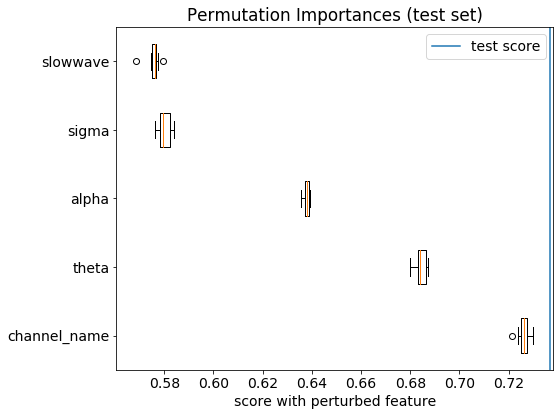

In [12]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/feature_permutation.png')
plt.show()